--- Customer Churn Prediction & Intervention (Colab Version) ---
This script simulates customer behavior and uses a simplified recurrent model with Monte Carlo simulation to predict churn risk and suggest interventions.
----------------------------------------------------------------------
Generating synthetic customer data...
Generated 50 customers.

--- Customer Selection ---
Available Customers:
  1. CUST-0000
  2. CUST-0001
  3. CUST-0002
  4. CUST-0003
  5. CUST-0004
  6. CUST-0005
  7. CUST-0006
  8. CUST-0007
  9. CUST-0008
  10. CUST-0009
  11. CUST-0010
  12. CUST-0011
  13. CUST-0012
  14. CUST-0013
  15. CUST-0014
  16. CUST-0015
  17. CUST-0016
  18. CUST-0017
  19. CUST-0018
  20. CUST-0019
  21. CUST-0020
  22. CUST-0021
  23. CUST-0022
  24. CUST-0023
  25. CUST-0024
  26. CUST-0025
  27. CUST-0026
  28. CUST-0027
  29. CUST-0028
  30. CUST-0029
  31. CUST-0030
  32. CUST-0031
  33. CUST-0032
  34. CUST-0033
  35. CUST-0034
  36. CUST-0035
  37. CUST-0036
  38. CUST-0037

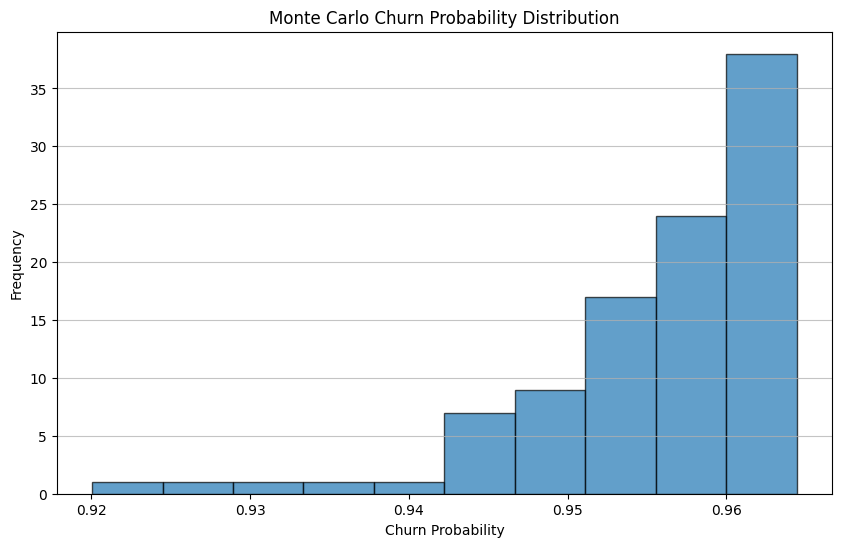


--- Suggested Intervention Strategy ---
Title: High Churn Risk: Urgent Intervention Needed!
Description: This customer is highly likely to churn soon. Immediate and personalized action is critical.
Recommended Actions:
- Personalized email/call from Account Manager to understand concerns.
- Offer a significant discount or tailored loyalty program.
- Conduct a 'win-back' survey if churn is imminent.

Disclaimer: This is a simplified simulation for demonstration purposes. Real-world churn prediction requires complex models, extensive data, and validation.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

# --- Configuration ---
random.seed(42)
np.random.seed(42)

# --- Data Simulation Functions ---

def generate_customer_events(num_days, churn_propensity, activity_base_rate=0.5):
    """Generates a sequence of simulated customer events."""
    events = []
    current_date = datetime.now() - timedelta(days=num_days)
    churned = False
    churn_day = None

    for day in range(num_days):
        # Simulate daily activity
        activity_prob = activity_base_rate * (1 - churn_propensity) # Higher propensity, lower activity
        if random.random() < activity_prob:
            event_type = random.choice(['login', 'view_feature', 'make_purchase', 'support_query', 'upgrade_plan'])
            events.append({'date': current_date.strftime('%Y-%m-%d'), 'type': event_type})
        else:
            events.append({'date': current_date.strftime('%Y-%m-%d'), 'type': 'inactivity'})

        # Simulate churn based on propensity
        daily_churn_prob = churn_propensity / num_days # Distribute propensity over days
        if not churned and random.random() < daily_churn_prob:
            churned = True
            churn_day = day
            events.append({'date': current_date.strftime('%Y-%m-%d'), 'type': 'churned'})
            break # Customer churns, no more events

        current_date += timedelta(days=1)

    return events, churned, churn_day

def simulate_customer_data(num_customers=100):
    """Generates synthetic customer dataset."""
    customers = []
    for i in range(num_customers):
        customer_id = f"CUST-{i:04d}"
        start_date = datetime.now() - timedelta(days=random.randint(30, 365))
        num_days_active = (datetime.now() - start_date).days

        # Churn propensity: higher value means higher likelihood of churning
        churn_propensity = np.random.beta(a=1, b=5) # Skewed towards lower churn

        events, churned, churn_day_idx = generate_customer_events(num_days_active, churn_propensity)

        churn_date = None
        if churned:
            # Find the actual churn event date from the events list
            churn_event = next((e for e in events if e['type'] == 'churned'), None)
            if churn_event:
                churn_date = churn_event['date']
            else: # Fallback in case 'churned' event wasn't explicitly added
                churn_date = (start_date + timedelta(days=churn_day_idx)).strftime('%Y-%m-%d')

        customers.append({
            'customer_id': customer_id,
            'start_date': start_date.strftime('%Y-%m-%d'),
            'last_activity_date': events[-1]['date'] if events else start_date.strftime('%Y-%m-%d'),
            'churned': churned,
            'churn_date': churn_date,
            'events': events,
            'churn_propensity_true': churn_propensity # For evaluation/comparison
        })
    return pd.DataFrame(customers)

# --- Simplified "RNN" Model Simulation ---

def predict_churn_risk_simplified_rnn(event_sequence, customer_history_length=30):
    """
    Simulates a simplified RNN-like model for churn prediction.
    It looks at recent activity patterns to infer churn risk.
    Higher risk for more 'inactivity' or 'support_query' events recently.
    """
    recent_events = event_sequence[-customer_history_length:] # Focus on recent history

    # Weighted sum of negative and positive events
    score = 0
    weights = np.linspace(0.1, 1.0, len(recent_events)) # More recent events have higher weight

    for i, event in enumerate(recent_events):
        weight = weights[i]
        if event['type'] == 'inactivity':
            score += 0.2 * weight # Inactivity strongly increases risk
        elif event['type'] == 'support_query':
            score += 0.15 * weight # Support queries increase risk
        elif event['type'] == 'make_purchase':
            score -= 0.1 * weight # Purchases decrease risk
        elif event['type'] == 'upgrade_plan':
            score -= 0.2 * weight # Upgrades significantly decrease risk
        elif event['type'] == 'login' or event['type'] == 'view_feature':
            score -= 0.05 * weight # General activity decreases risk

    # Map score to a churn probability (sigmoid-like function)
    churn_prob = 1 / (1 + np.exp(-score))
    return min(1.0, max(0.0, churn_prob)) # Ensure probability is between 0 and 1

# --- Monte Carlo Simulation for Churn ---

def monte_carlo_churn_prediction(customer_data, num_simulations=100, forecast_days=90):
    """
    Performs Monte Carlo simulations to predict future churn risk.
    For each simulation, it projects future events and re-evaluates churn.
    """
    churn_probabilities = []

    # Get current churn risk based on historical data
    current_risk = predict_churn_risk_simplified_rnn(customer_data['events'])

    # Simulate future activity for the next 'forecast_days'
    for _ in range(num_simulations):
        simulated_events_for_forecast = []
        sim_current_date = datetime.strptime(customer_data['last_activity_date'], '%Y-%m-%d') + timedelta(days=1)

        for day in range(forecast_days):
            # Simulate daily activity for the future based on current risk
            # Higher current risk implies lower future positive activity likelihood
            activity_prob = 0.6 * (1 - current_risk) # Adjust base activity by current risk
            if random.random() < activity_prob:
                event_type = random.choice(['login', 'view_feature', 'make_purchase', 'support_query'])
                simulated_events_for_forecast.append({'date': sim_current_date.strftime('%Y-%m-%d'), 'type': event_type})
            else:
                simulated_events_for_forecast.append({'date': sim_current_date.strftime('%Y-%m-%d'), 'type': 'inactivity'})

            sim_current_date += timedelta(days=1)

        # Combine historical and simulated future events for evaluation
        # The 'RNN' here is just a function that processes a sequence.
        # It's not a truly recurrent network, but simulates its behavior.
        full_event_sequence = customer_data['events'] + simulated_events_for_forecast

        # Re-evaluate churn probability with the simulated future
        sim_churn_prob = predict_churn_risk_simplified_rnn(full_event_sequence)
        churn_probabilities.append(sim_churn_prob)

    return np.mean(churn_probabilities), np.std(churn_probabilities), churn_probabilities

# --- Intervention Strategy ---

def suggest_intervention(churn_probability):
    """Suggests interventions based on churn probability."""
    if churn_probability >= 0.7:
        return {
            "title": "High Churn Risk: Urgent Intervention Needed!",
            "description": "This customer is highly likely to churn soon. Immediate and personalized action is critical.",
            "actions": [
                "Personalized email/call from Account Manager to understand concerns.",
                "Offer a significant discount or tailored loyalty program.",
                "Conduct a 'win-back' survey if churn is imminent."
            ],
            "color": "red" # Color is for display, will be mapped to text output
        }
    elif churn_probability >= 0.4:
        return {
            "title": "Moderate Churn Risk: Proactive Engagement Advised.",
            "description": "There's a noticeable risk of churn. Proactive measures can help retain this customer.",
            "actions": [
                "Send targeted content or feature usage tips.",
                "Offer a small, personalized incentive.",
                "Gather feedback through a short survey on recent experience."
            ],
            "color": "orange"
        }
    else:
        return {
            "title": "Low Churn Risk: Monitor & Nurture.",
            "description": "Customer seems stable, but continuous nurturing is always beneficial.",
            "actions": [
                "Continue regular communication and product updates.",
                "Encourage participation in community or beta programs.",
                "Maintain high-quality support and service."
            ],
            "color": "green"
        }

# --- Script Execution for Colab ---

print("--- Customer Churn Prediction & Intervention (Colab Version) ---")
print("This script simulates customer behavior and uses a simplified recurrent model with Monte Carlo simulation to predict churn risk and suggest interventions.")
print("-" * 70)

# Load or generate data
print("Generating synthetic customer data...")
df_customers = simulate_customer_data(num_customers=50)
print(f"Generated {len(df_customers)} customers.")

# Allow user to select a customer by index or list them
print("\n--- Customer Selection ---")
print("Available Customers:")
for i, cust_id in enumerate(df_customers['customer_id'].tolist()):
    print(f"  {i+1}. {cust_id}")

while True:
    try:
        selection_input = input("Enter the number of the customer to analyze (e.g., 1, 2, ...): ")
        selected_index = int(selection_input) - 1
        if 0 <= selected_index < len(df_customers):
            selected_customer = df_customers.iloc[selected_index]
            break
        else:
            print("Invalid number. Please enter a number from the list.")
    except ValueError:
        print("Invalid input. Please enter a number.")

selected_customer_id = selected_customer['customer_id']
print(f"\nAnalyzing Customer: {selected_customer_id}")
print("-" * 70)

print("\n--- Customer Overview ---")
print(f"Start Date: {selected_customer['start_date']}")
print(f"Last Activity Date: {selected_customer['last_activity_date']}")
if selected_customer['churned']:
    print(f"Status: CHURNED on {selected_customer['churn_date']}")
else:
    print("Status: Active")
print(f"(True Churn Propensity: {selected_customer['churn_propensity_true']:.2f})")

print("\n--- Recent Customer Activity ---")
event_df = pd.DataFrame(selected_customer['events'])
if not event_df.empty:
    print(event_df.tail(10).to_string()) # Display recent events
else:
    print("No recent activity recorded for this customer.")

print("\n--- Churn Prediction using Monte Carlo Simulation ---")
input("Press Enter to predict churn risk (this will run Monte Carlo simulations)...") # Acts as a "button"

print("Running Monte Carlo Simulations for churn prediction...")
mean_churn_prob, std_churn_prob, all_probs = monte_carlo_churn_prediction(selected_customer)

print("\n--- Prediction Results ---")
print(f"Predicted Churn Probability (Mean): {mean_churn_prob:.2f}")
print(f"Standard Deviation of Predictions (from MC): {std_churn_prob:.2f}")

# Visualize distribution of probabilities
print("\nDisplaying distribution of Churn Probabilities from Monte Carlo Simulations...")
plt.figure(figsize=(10, 6))
plt.hist(all_probs, bins=10, edgecolor='black', alpha=0.7)
plt.title("Monte Carlo Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\n--- Suggested Intervention Strategy ---")
intervention = suggest_intervention(mean_churn_prob)
print(f"Title: {intervention['title']}")
print(f"Description: {intervention['description']}")
print("Recommended Actions:")
for action in intervention['actions']:
    print(f"- {action}")

print("\n" + "=" * 70)
print("Disclaimer: This is a simplified simulation for demonstration purposes. Real-world churn prediction requires complex models, extensive data, and validation.")
print("=" * 70)